In [ ]:
# change working directory to the root of the project
import os
os.chdir('..')

In [2]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import pyprotoevo

sim_name = 'gaia-seadra-voluptas'

In [4]:
sim_files = pyprotoevo.utils.SimulationFiles(sim_name)

In [5]:
import json


def read_json(path):
    with open(path) as f:
        return json.load(f)


stats_dir = sim_files.save_dir  / 'stats/summaries'
genomes_dir = sim_files.save_dir / 'stats/protozoa-genomes'

stats = {
    f.stem: read_json(f) for f in stats_dir.glob('*.json')
}

In [6]:
genomes = {
    f.stem: read_json(f) for i, f in enumerate(genomes_dir.glob('*.json'))
    if i % 50 == 0
}

In [7]:
all_stats = set(stat for time_stamp in stats for stat in stats[time_stamp]['stats'])

In [8]:
black_list = ['Node ', 'Organelle', 'Log', 'Molecule']
basic_stats = [
    stat for stat in all_stats
    if all(x not in stat for x in black_list)
]
print('\n'.join(basic_stats))

Num Spikes Min
Speed Min
Num Cell Bindings Mean
Available Energy Min
GRN Size Max
Total Mass Mean
Plant to Digest Max
Multicell Structure Size Count
Death Rate Max
Died from cytokinesis
Health Max
Has Mated Min
Crossover Events
Health Min
Multicell Structure Size Mean
Died from overcrowding
GRN Size Mean
Split Radius Max
Joints
Construction Mass Limit Mean
Light Sensitive Nodes Max
Growth Rate Max
Meat Digestion Rate Min
Generation Mean
Meat Created
Meat Digestion Rate Mean
Died from suffocation
Has Mated Max
Protozoa Created
Available Energy Mean
Being Engulfed Max
Growth Rate Min
Plant to Digest Min
Age Min
Mean Mutation Chance Mean
GRN Depth Max
Energy Limit Min
Mean Mutation Chance Min
Meat Digestion Rate Max
Meat to Digest Max
Meat to Digest Mean
Growth Rate Mean
Died from being healed to death?...
Num Cell Bindings Max
Max Plant Generation
Generation Max
Died from exceeding environment capacity
Plant Digestion Rate Mean
Num Mutations Max
GRN Depth Min
Energy Limit Mean
Mean Mutat

In [9]:
stat_types = {
    stat: record['unit']['units']
    for time_stamp in stats.keys()
    for stat, record in stats[time_stamp]['stats'].items()
    if record['unit'] is not None
}

In [10]:
def unit_to_string(unit: dict) -> str:
    '''
    Convert a unit dictionary to a string.
    For instance, {'MASS': 1, 'TIME': -1} becomes 'µg/s'.
    Possible base units are:
    - MASS: converted to micrograms (1e-6)
    - DISTANCE: converted to micrometers (1e-6)
    - TIME: converted to seconds (1)
    - ENERGY: converted to joules (1)
    - COUNT: converted to number (1)
    - ANGLE: converted to radians (1)
    - PERCENTAGE: converted to percentage (1)
    '''
    units = {
        'MASS': 'µg',
        'DISTANCE': 'µm',
        'TIME': 's',
        'ENERGY': 'J',
        'COUNT': '',
        'ANGLE': 'rad',
        'PERCENTAGE': '%'
    }
    return ''.join([
        units[key] + ('' if val == 1 else '^{' + str(val) + '}')
        for key, val in unit.items()
    ])

In [11]:
stat_type_strs = {
    stat: unit_to_string(unit)
    for stat, unit in stat_types.items()
}

In [12]:
def get_stat_value(stats, stat_name):
    return stats['stats'][stat_name]['value']

In [13]:
from datetime import datetime

In [14]:
generation_df = pd.DataFrame([
    {
        'Time': datetime(*map(int, time_stamp.split('-'))),
        'Time Stamp': time_stamp,
        'Generation': get_stat_value(stats_at_time, 'Max Protozoa Generation'),
    }
    for time_stamp, stats_at_time in stats.items()
]);
generation_df['Wall Time'] = generation_df['Time'] - generation_df['Time'].min()
generation_df['Next Time Stamp'] = generation_df['Time Stamp'].shift(-1)
generation_df.head()

,Time,Time Stamp,Generation,Wall Time,Next Time Stamp
0,2023-03-05 16:52:35,2023-03-05-16-52-35,1,0 days 00:00:00,2023-03-05-16-59-20
1,2023-03-05 16:59:20,2023-03-05-16-59-20,2,0 days 00:06:45,2023-03-05-17-07-11
2,2023-03-05 17:07:11,2023-03-05-17-07-11,3,0 days 00:14:36,2023-03-05-17-15-02
3,2023-03-05 17:15:02,2023-03-05-17-15-02,3,0 days 00:22:27,2023-03-05-17-23-10
4,2023-03-05 17:23:10,2023-03-05-17-23-10,3,0 days 00:30:35,2023-03-05-17-31-25


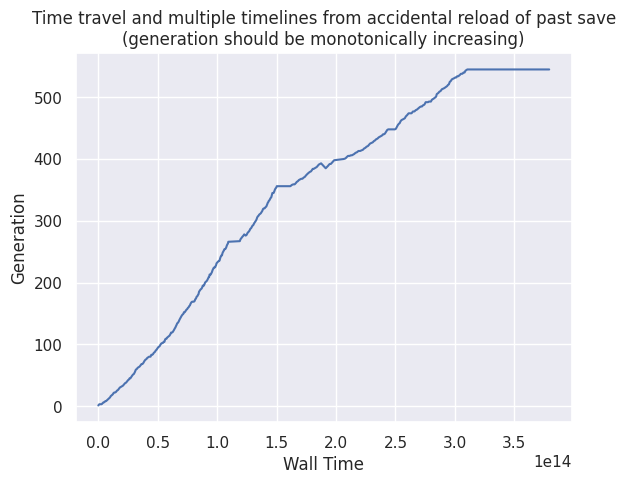

In [15]:
plt.title('Time travel and multiple timelines from accidental reload of past save\n(generation should be monotonically increasing)')
sns.lineplot(data=generation_df, x='Wall Time', y='Generation');

In [16]:
generation_df = generation_df.sort_values('Time Stamp')
records = generation_df.to_records()


def are_all_future_records_of_higher_generation(record):
    return all(
        record['Generation'] < records[i]['Generation']
        for i in range(record['index'] + 1, len(records))
    )


cleaned_stats = {
    (time_stamp := record['Time Stamp']) : stats[time_stamp]
    for record in records
    if are_all_future_records_of_higher_generation(record)
}

In [17]:
def get_datetime(time_stamp: str) -> datetime:
    return datetime(*map(int, time_stamp.split('-')))

In [18]:
generation_df_cleaned = pd.DataFrame([
    {
        'Time': get_datetime(time_stamp),
        'Time Stamp': time_stamp,
        'Generation': get_stat_value(stats_at_time, 'Max Protozoa Generation'),
    }
    for time_stamp, stats_at_time in cleaned_stats.items()
]);
generation_df_cleaned['Wall Time'] = generation_df_cleaned['Time'] - generation_df_cleaned['Time'].min()

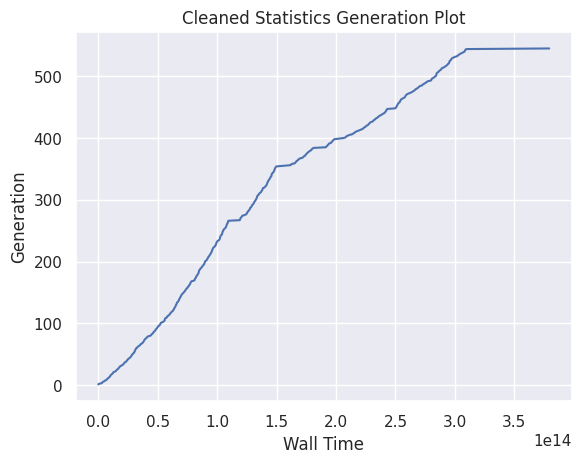

In [19]:
plt.title('Cleaned Statistics Generation Plot')
sns.lineplot(data=generation_df_cleaned, x='Wall Time', y='Generation');

In [20]:
stats = cleaned_stats

Being Engulfed
Meat Digestion Rate
Age
Repair Rate
Plant Digestion Rate
Generation
Health
Growth Rate
Num Spikes
Energy Limit
Construction Mass
Meat
GRN Size
Plants
Speed
Herbivore Factor
Num Engulfed
Total Mass
Num Mutations
Plant to Digest
Split Radius
Construction Mass Limit
Size
GRN Depth
Mean Mutation Chance
Light Sensitive Nodes
Available Energy
Death Rate
Meat to Digest
Protozoa
Multicell Structure Size
Has Mated
Num Cell Bindings


,Total Mass Mean,Crossover Events,GRN Size Mean,Joints,Construction Mass Limit Mean,Generation Mean,Meat Digestion Rate Mean,Protozoa Created,Available Energy Mean,Mean Mutation Chance Mean,...,Generation Min,Num Mutations Min,Construction Mass Max,Repair Rate Max,Construction Mass Limit Min,Num Engulfed Max,Age Max,Being Engulfed Min,Light Sensitive Nodes Min,Died from being healed to death?...
0,0.022418,0,40.423333,0,0.001552,1.000000,0.899004,300,1.000000,3.506762,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.008981,0,40.430464,2711,0.001095,1.092715,0.881301,314,11.934544,3.500610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.014043,0,40.666667,3183,0.001624,1.820513,0.887169,465,1360.371682,3.425551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.014519,0,40.745763,3227,0.001633,2.423729,0.919816,516,1649.368820,3.413523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.017284,0,40.796610,3276,0.001792,3.254237,0.861272,559,1968.738545,3.378033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
stats_df = pd.DataFrame([
    {
        stat: get_stat_value(stats[time_stamp], stat)
        for stat in basic_stats
        if stat in stats[time_stamp]['stats']
    }
    for time_stamp in stats.keys()
])

import re

stat_names = {
    match.group(1) for stat in stats_df.columns 
    if (match := re.match(r'(.*) [Mean|Max|Min|Count]', stat))
    and 'Died' not in stat
}
print('\n'.join(stat_names))

# for stat in stats:
#     stats_df[stats_df[stat + 'Min']]

# # stats_df.fillna(0, inplace=True)
stats_df.replace(to_replace='NaN', value=np.nan, inplace=True)
stats_df.head()

In [22]:
attachment_types = {
    match.group(2) for stat in all_stats
    if (match := re.match(r'(.*): (.*) Construction Progress Mean', stat))
}
attachment_types

{'Binding', 'Flagellum', 'Phagocytic Receptor', 'Photoreceptor', 'Spike'}

In [23]:
node_prefixes = {
    match.group(1) for stat in all_stats
    if (match := re.match(r'(.*): (.*) Construction Progress Mean', stat))
}
node_prefixes

{'Node 0',
 'Node 1',
 'Node 10',
 'Node 11',
 'Node 2',
 'Node 3',
 'Node 4',
 'Node 5',
 'Node 6',
 'Node 7',
 'Node 8',
 'Node 9'}

In [24]:
def get_counts(search_term):
    photo_stats_df = pd.DataFrame([
        {'Generation': get_stat_value(stats[time_stamp], 'Max Protozoa Generation'), **{
            stat: get_stat_value(stats[time_stamp], stat)
            for stat in all_stats
            if search_term in stat and 'Count' in stat and stat in stats[time_stamp]['stats']
        }}
        for time_stamp in stats.keys()
    ])
    photo_stats_df.fillna(0, inplace=True)
    return photo_stats_df[[col for col in photo_stats_df.columns if search_term in col]].sum(axis=1)

In [25]:
# node stats only present with the corresponding attachment types
search_term_nodes = {
    'Red Light': 'Photoreceptor',
    'Thrust': 'Flagellum',
    'Engulfed Cells': 'Phagocytosis receptor',
    'Binding': 'Adhesion receptor',
}

for search_term in search_term_nodes:
    node_type = search_term_nodes[search_term]
    stats_df[f'{node_type} Count'] = get_counts(search_term)
    stat_names.add(node_type)

<AxesSubplot: xlabel='Max Protozoa Generation', ylabel='Protozoa'>

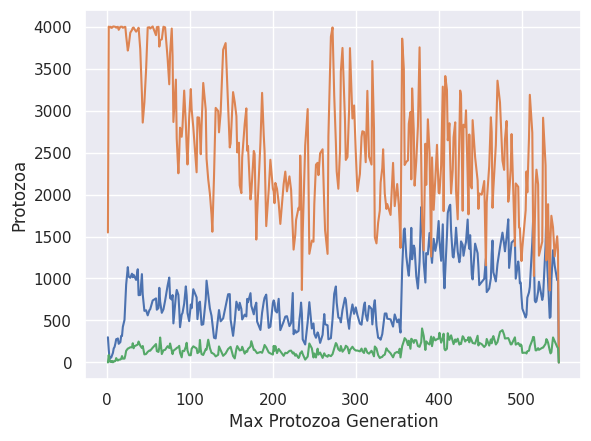

In [26]:
sns.lineplot(data=stats_df, x='Max Protozoa Generation', y='Protozoa')
sns.lineplot(data=stats_df, x='Max Protozoa Generation', y='Plants')
sns.lineplot(data=stats_df, x='Max Protozoa Generation', y='Meat Pellets')

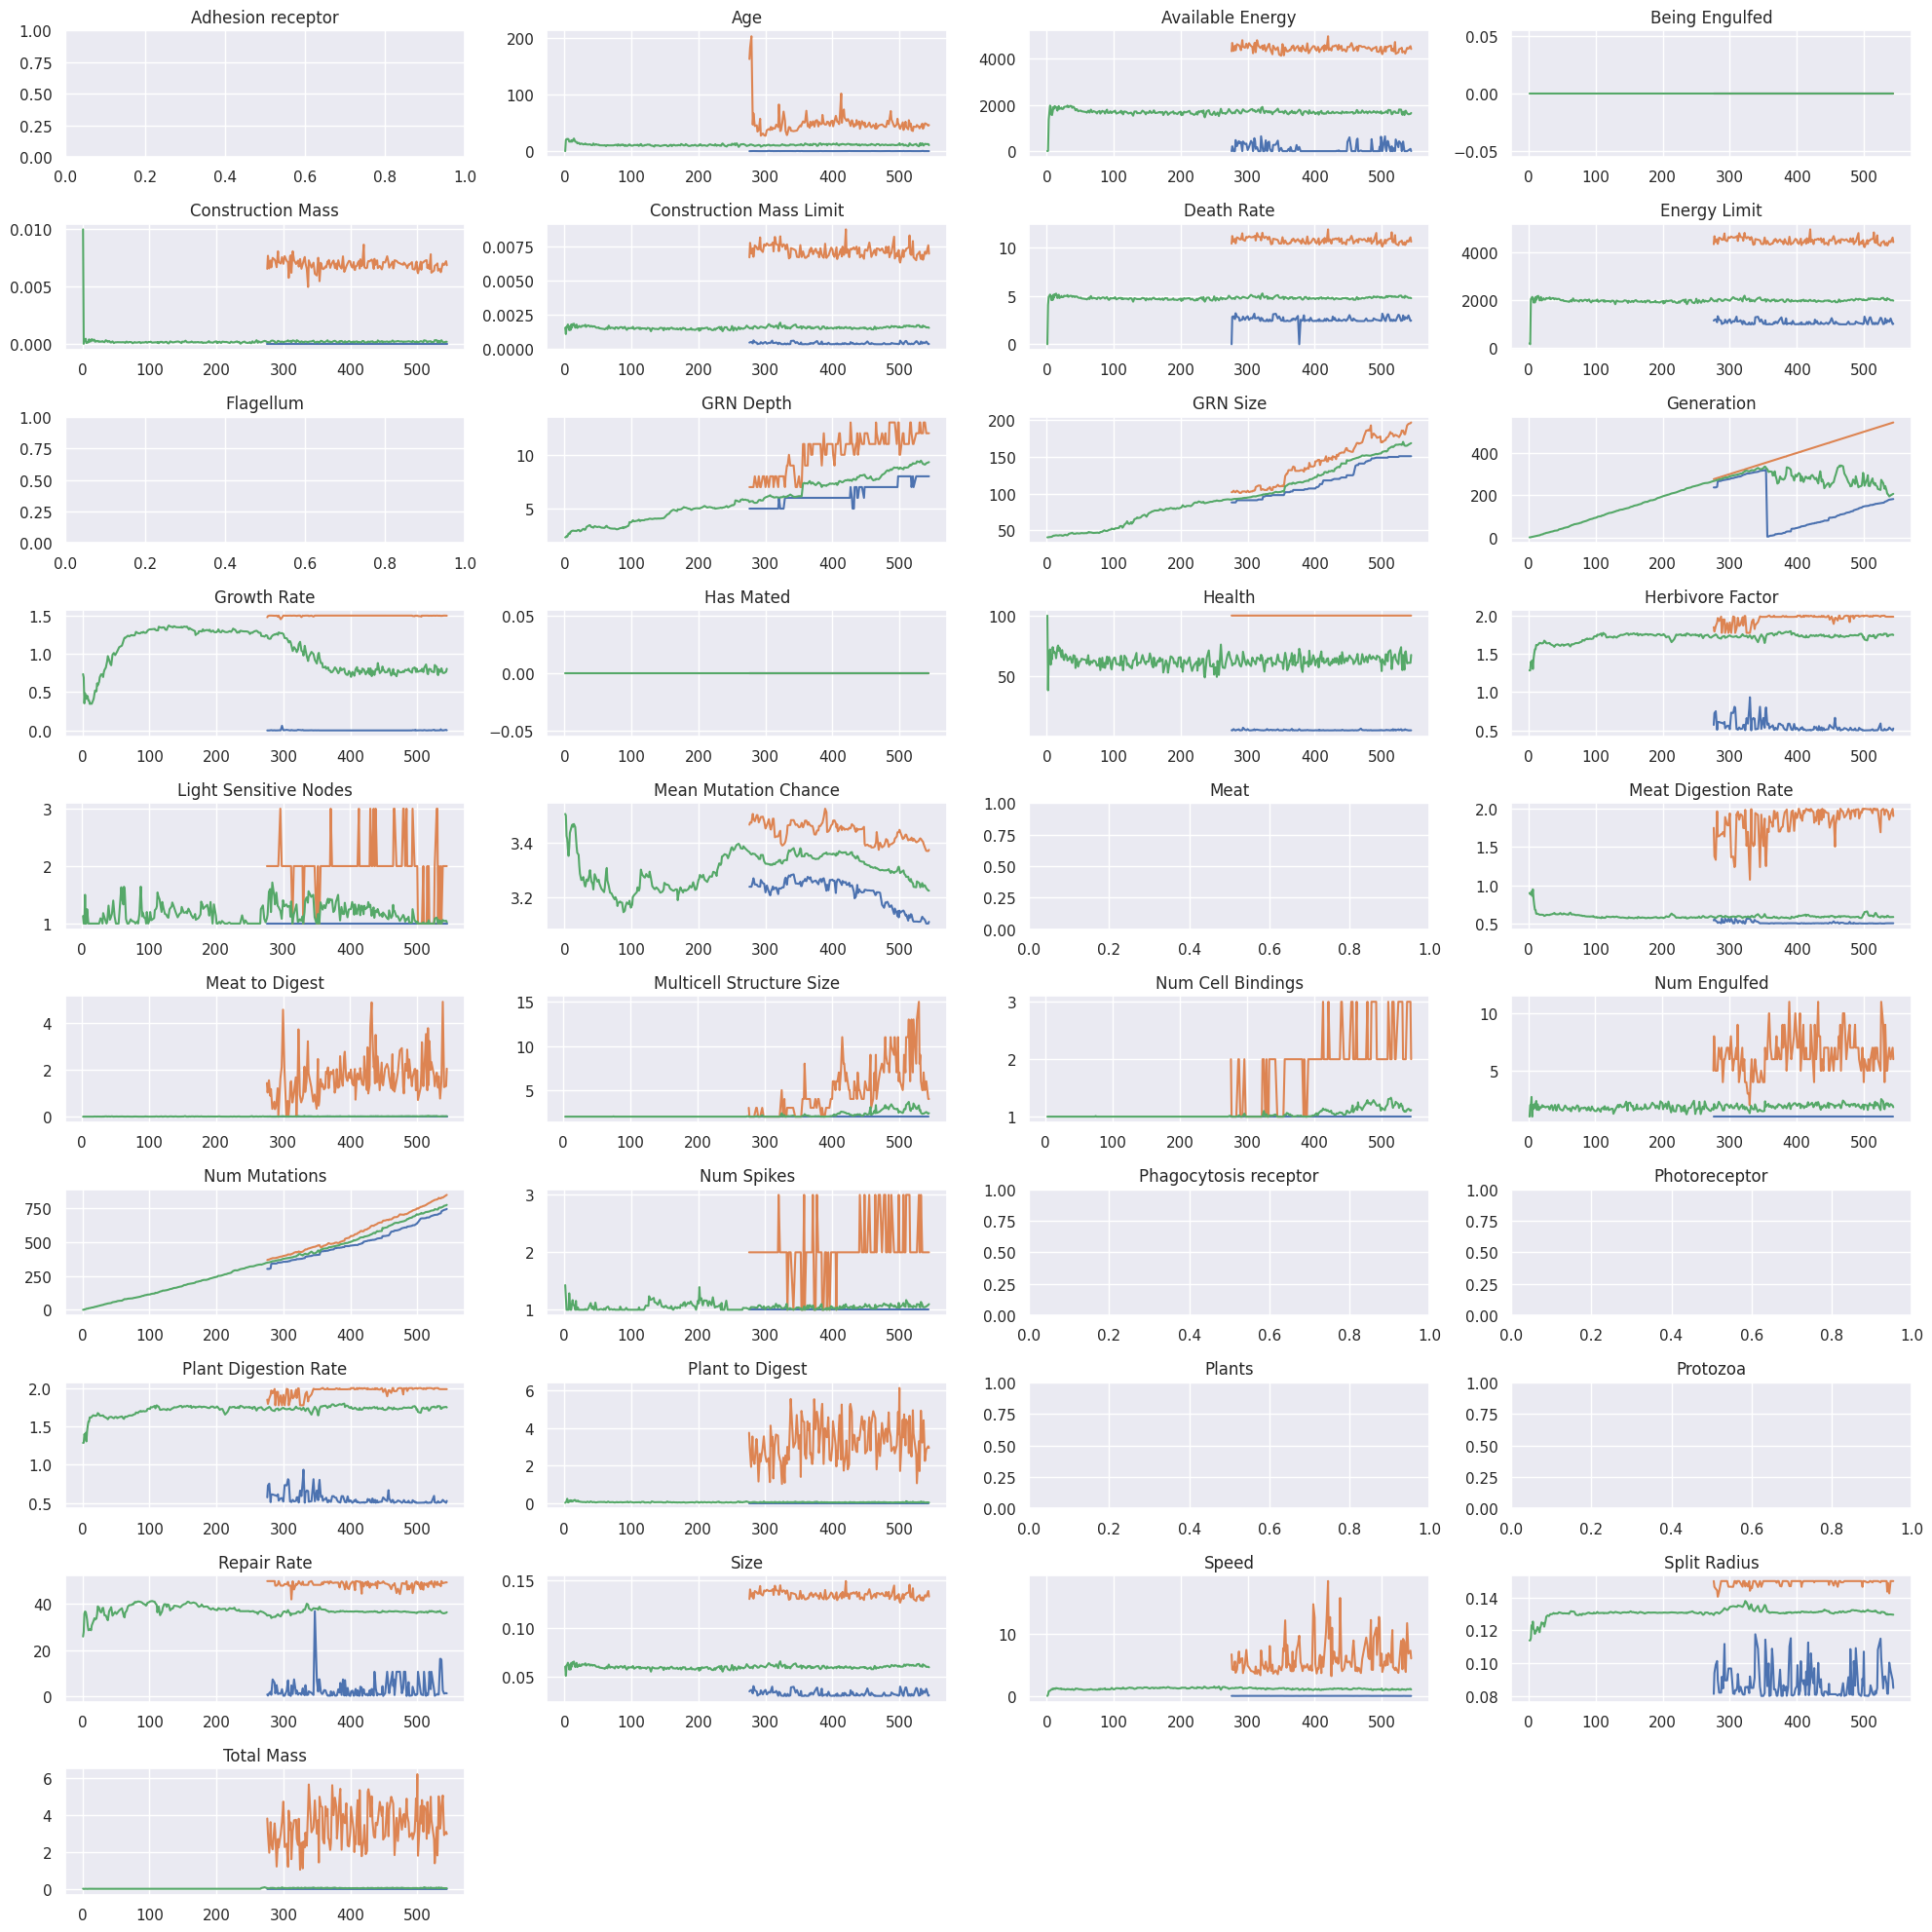

In [27]:
# n = int(np.ceil(np.sqrt(stats_df.columns.size)))
cols = 4
rows = int(np.ceil(len(stat_names) / cols))


import itertools

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 2))
for ax, stat in itertools.zip_longest(axes.flatten(), sorted(stat_names)):
    if stat is not None:
        for stat_type in ['Min', 'Max', 'Mean']: 
            variable = f'{stat} {stat_type}'
            if variable in stats_df.columns:
                sns.lineplot(data=stats_df, x='Max Protozoa Generation', y=variable, ax=ax)
        ax.set_title(stat)
        ax.set_xlabel('')
        if stat in stat_type_strs and stat_type_strs[stat] != '':
            ax.set_ylabel(f'${stat_type_strs[stat]}$'.replace('%', r'\%'))
        else:
            ax.set_ylabel('')
    else:
        ax.axis('off')


plt.tight_layout()
plt.show()

In [28]:
for stat in stat_names:
    if stat + ' Count' in stats_df.columns:
        stats_df[stat + ' Frequency'] = stats_df[stat + ' Count'] / stats_df['Protozoa']

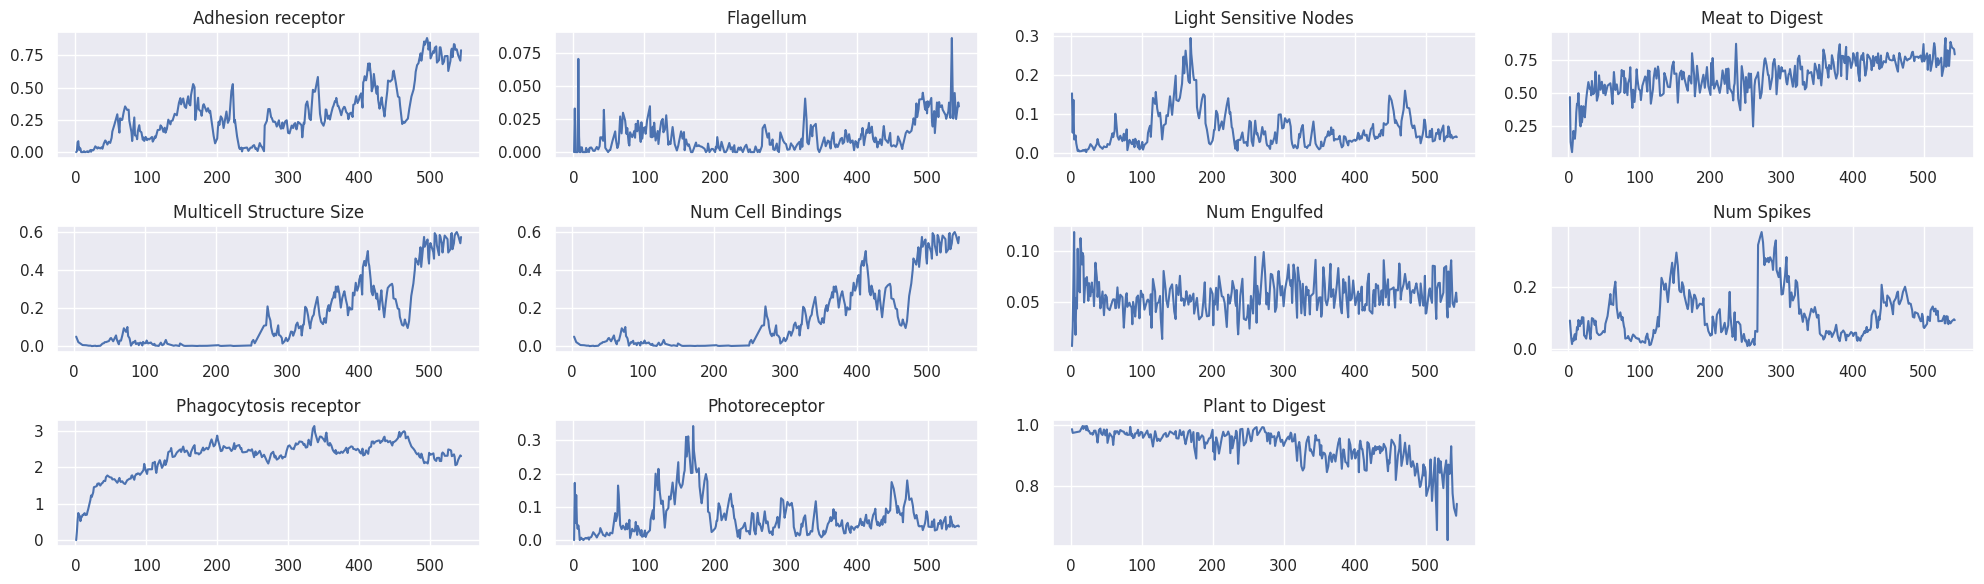

In [29]:
# n = int(np.ceil(np.sqrt(stats_df.columns.size)))
cols = 4
stats_with_counts = [stat for stat in stat_names if stat + ' Count' in stats_df.columns]
n_plots = len(stats_with_counts)
rows = int(np.ceil(n_plots / cols))


import itertools

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 2))
for ax, stat in itertools.zip_longest(axes.flatten(), sorted(stats_with_counts)):
    if stat is not None:
        variable = f'{stat} Frequency'
        if variable in stats_df.columns:
            sns.lineplot(data=stats_df, x='Max Protozoa Generation', y=variable, ax=ax)
            ax.set_title(stat)
        ax.set_xlabel('')
        if stat in stat_type_strs and stat_type_strs[stat] != '':
            ax.set_ylabel(f'${stat_type_strs[stat]}$'.replace('%', r'\%'))
        else:
            ax.set_ylabel('')
    else:
        ax.axis('off')


plt.tight_layout()
plt.show()

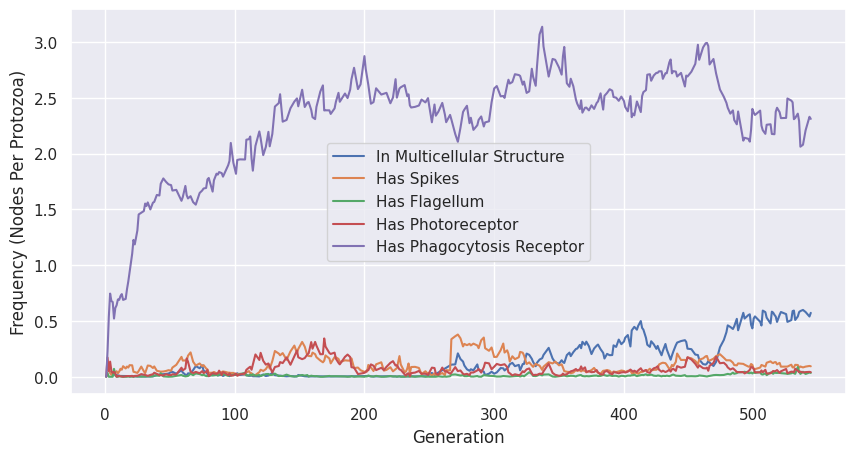

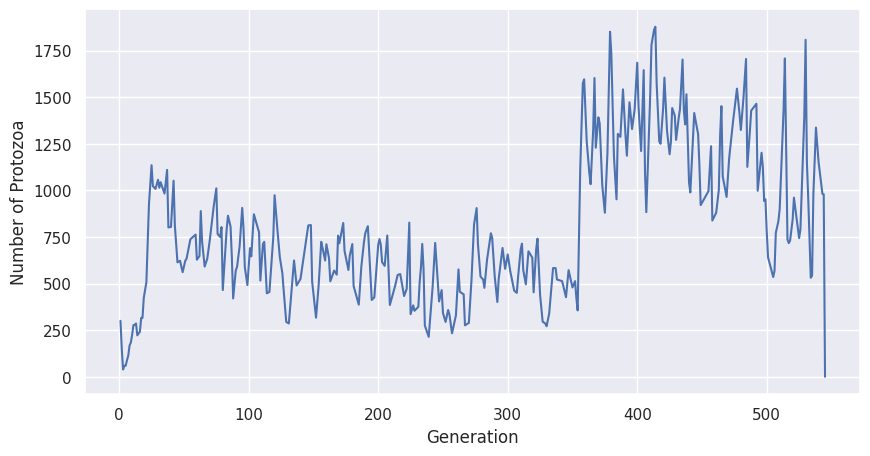

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))

labels_map = {
    'Multicell Structure Size': 'In Multicellular Structure',
    'Num Spikes': 'Has Spikes',
    'Flagellum': 'Has Flagellum',
    'Photoreceptor': 'Has Photoreceptor',
    'Phagocytosis receptor': 'Has Phagocytosis Receptor',
    # 'Adhesion receptor': 'Has Adhesion Receptor',
}

for stat in labels_map:
    sns.lineplot(data=stats_df, x='Max Protozoa Generation', y=f'{stat} Frequency', ax=ax, label=labels_map[stat])

ax.set_ylabel('Frequency (Nodes Per Protozoa)')
ax.set_xlabel('Generation')

plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=stats_df, x='Max Protozoa Generation', y='Protozoa', ax=ax)
ax.set_ylabel('Number of Protozoa')
ax.set_xlabel('Generation')
plt.show()

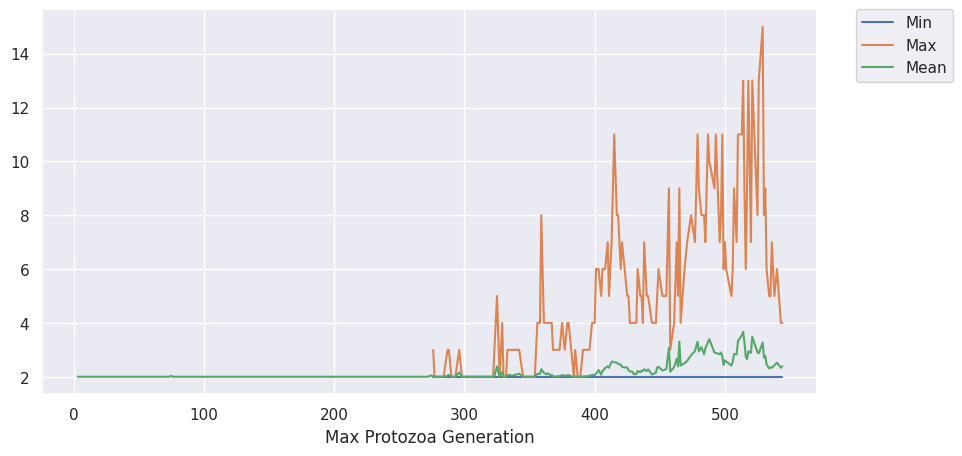

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
stat = 'Multicell Structure Size'

stat_df = stats_df[[f'{stat} {suffix}' for suffix in ['Min', 'Max', 'Mean']] + ['Max Protozoa Generation']]

# is_nan = stat_df[stat + ' Min'].isna()
# stat_df[stat + ' Min'][is_nan] = stat_df[stat + ' Mean'][is_nan] 

for suffix in ['Min', 'Max', 'Mean']:
    sns.lineplot(data=stat_df, x='Max Protozoa Generation', y=f'{stat} {suffix}', ax=ax, label=suffix)

if stat in stat_type_strs and stat_type_strs[stat] != '':
    ax.set_ylabel(f'${stat_type_strs[stat]}$'.replace('%', r'\%'))
else:
    ax.set_ylabel('')

# place legend outside of plot to the right
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [32]:
def create_counts_df(time, genomes):
    df = pd.DataFrame([
        {'signature': gene['signature']}
        for genome in genomes
        for gene in genome['sensorNeuronGenes'] + genome['outputNeuronGenes'] + genome['hiddenNeuronGenes'] + genome['synapseGenes']
    ]).value_counts().reset_index().rename(columns={0: 'count'})
    df['time'] = time
    df['generation'] = get_stat_value(stats[time], 'Generation Mean')
    df['num_protozoa'] = get_stat_value(stats[time], 'Protozoa')
    df['frequency'] = df['count'] / df['num_protozoa']
    return df

gene_signatures_df = pd.concat([
    create_counts_df(time, genomes)
    for time, genomes in genomes.items()
    if time in stats
])

In [33]:
gene_signatures_df

,signature,count,time,generation,num_protozoa,frequency
0,-9223239949182548345,1,2023-03-05-16-52-35,1.000000,300,0.003333
1,3111382536755560872,1,2023-03-05-16-52-35,1.000000,300,0.003333
2,3108648323931458203,1,2023-03-05-16-52-35,1.000000,300,0.003333
3,3109380954978601831,1,2023-03-05-16-52-35,1.000000,300,0.003333
4,3109817975278749086,1,2023-03-05-16-52-35,1.000000,300,0.003333
...,...,...,...,...,...,...
4159,2451175864105781427,1,2023-03-09-06-41-27,204.514781,981,0.001019
4160,2419152873650471983,1,2023-03-09-06-41-27,204.514781,981,0.001019
4161,-5350053126516096731,1,2023-03-09-06-41-27,204.514781,981,0.001019
4162,-5349555975894774597,1,2023-03-09-06-41-27,204.514781,981,0.001019


In [34]:
variance_df = gene_signatures_df.groupby('signature')\
    .var()\
    .rename(columns={name: f'var {name}' for name in gene_signatures_df.columns})\
    .sort_values('var frequency', ascending=False).dropna().take(range(500))\
    .reset_index()
variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency
0,-6832950671583721871,234139.000000,1103.063974,99570.333333,0.242836
1,5167132510654251732,234139.000000,1103.063974,99570.333333,0.242836
2,6394353854173758477,234139.000000,1103.063974,99570.333333,0.242836
3,7943275609061215519,233622.333333,1103.063974,99570.333333,0.242535
4,-4013311183576150124,507719.000000,1203.078271,212941.583333,0.236374


In [35]:
high_var_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(variance_df['signature'])]
# pivot signature to columns with fixation as values
high_var_genes_df_pivot = high_var_genes_df.pivot(index='generation', columns='signature', values='frequency')

In [36]:
reaches_high_freq = high_var_genes_df_pivot.max() >  0.85
reaches_high_freq_sigs = reaches_high_freq.index[reaches_high_freq.values].values

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


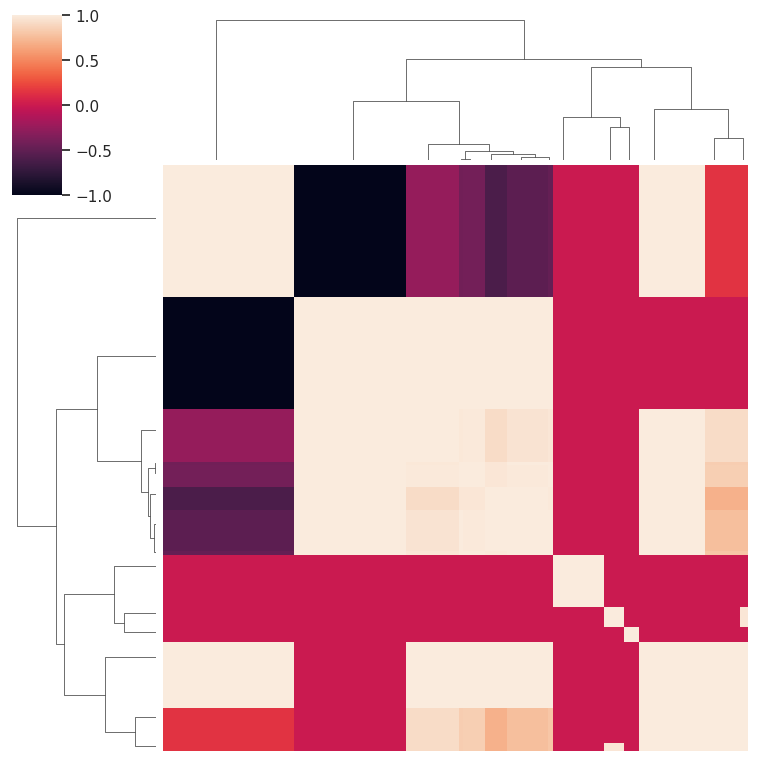

In [37]:
grid = sns.clustermap(high_var_genes_df_pivot.corr().fillna(0))
ax = grid.fig.axes[2]
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [38]:
import scipy.cluster.hierarchy as spc

corr = high_var_genes_df_pivot.corr().fillna(0).values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.05 * pdist.max(), 'distance')
signature_clusters = dict(zip(high_var_genes_df_pivot.columns, idx))
clusters_ids = np.unique(idx)
clusters = {
    cluster_id: [
        signature for signature, cluster in signature_clusters.items()
        if cluster == cluster_id
    ]
    for cluster_id in clusters_ids
}
clusters_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [39]:
def get_prototype(cluster_idx):
    signatures = [signature for signature, idx in signature_clusters.items() if idx == cluster_idx]
    cluster_df = variance_df[variance_df['signature'].isin(signatures)]
    return max(cluster_df.signature, key=lambda x: cluster_df[cluster_df['signature'] == x]['var frequency'].values[0])

cluster_prototypes = {
    cluster: get_prototype(cluster)
    for cluster in clusters
}

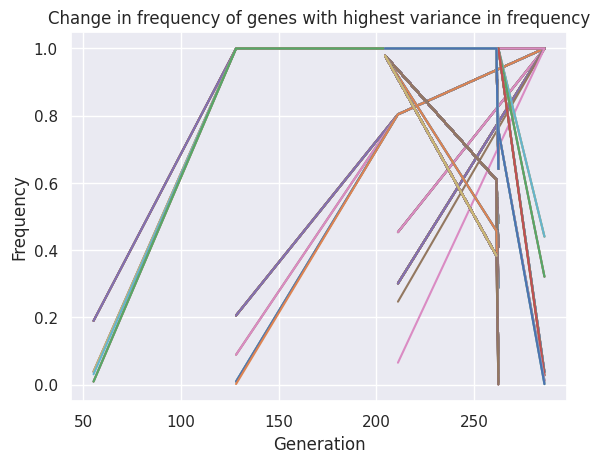

In [40]:
plot_sigs = high_var_genes_df['signature'][high_var_genes_df['signature'].isin(reaches_high_freq_sigs)].unique()

for gene in plot_sigs:
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'])
plt.xlabel('Generation')
plt.ylabel('Frequency')
plt.title('Change in frequency of genes with highest variance in frequency')
plt.show()

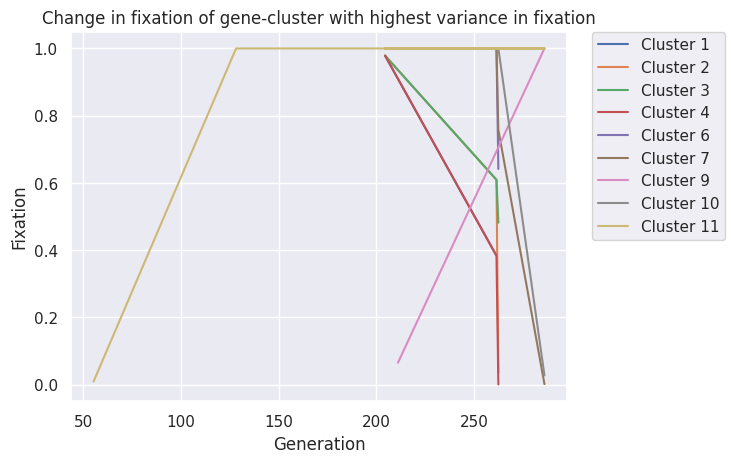

In [41]:
for cluster_id, gene in cluster_prototypes.items():
    if gene not in plot_sigs:
        continue
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'], label=f'Cluster {cluster_id}')
plt.xlabel('Generation')
plt.ylabel('Fixation')
plt.title('Change in fixation of gene-cluster with highest variance in fixation')
# legend outside of plot to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [42]:
last_generation_time_stamp = max(genomes.keys(), key=get_datetime)
last_generation_time_stamp

last_generation_signatures = set([
    gene['signature']
    for genome in genomes[last_generation_time_stamp]
    for gene in genome['sensorNeuronGenes'] + genome['outputNeuronGenes'] + genome['hiddenNeuronGenes'] + genome['synapseGenes']
])

survived_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(last_generation_signatures)]
survived_genes_df.head()

,signature,count,time,generation,num_protozoa,frequency


In [43]:
survived_variance_df = gene_signatures_df.groupby('signature')\
    .var()\
    .rename(columns={name: f'var {name}' for name in gene_signatures_df.columns})\
    .sort_values('var frequency', ascending=False).dropna().take(range(500))\
    .reset_index()
survived_variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency
0,-6832950671583721871,234139.000000,1103.063974,99570.333333,0.242836
1,5167132510654251732,234139.000000,1103.063974,99570.333333,0.242836
2,6394353854173758477,234139.000000,1103.063974,99570.333333,0.242836
3,7943275609061215519,233622.333333,1103.063974,99570.333333,0.242535
4,-4013311183576150124,507719.000000,1203.078271,212941.583333,0.236374


In [44]:
survived_high_var_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(survived_variance_df['signature'])]

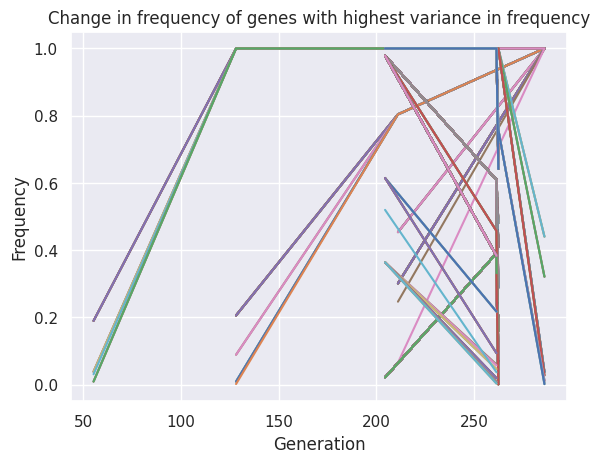

In [45]:
for gene in survived_high_var_genes_df['signature'].unique():
    gene_ts = survived_high_var_genes_df[survived_high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'])
plt.xlabel('Generation')
plt.ylabel('Frequency')
plt.title('Change in frequency of genes with highest variance in frequency')
plt.show()

In [46]:
variance_df['cluster id'] = variance_df['signature'].map(signature_clusters)
variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency,cluster id
0,-6832950671583721871,234139.000000,1103.063974,99570.333333,0.242836,4
1,5167132510654251732,234139.000000,1103.063974,99570.333333,0.242836,4
2,6394353854173758477,234139.000000,1103.063974,99570.333333,0.242836,4
3,7943275609061215519,233622.333333,1103.063974,99570.333333,0.242535,4
4,-4013311183576150124,507719.000000,1203.078271,212941.583333,0.236374,10


In [47]:
variance_df.groupby('cluster id').var()

,signature,var count,var generation,var num_protozoa,var frequency
cluster id,,,,,
1,2.863567e+37,1.613635e+08,0.000000e+00,0.000000e+00,2.042036e-03
2,3.187509e+37,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,1.927375e+37,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,2.922259e+37,5.242800e+09,0.000000e+00,0.000000e+00,3.129409e-03
5,2.795240e+37,4.058136e+04,0.000000e+00,0.000000e+00,7.474279e-09
6,2.760724e+37,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,3.502486e+37,3.343413e+06,0.000000e+00,0.000000e+00,5.586704e-06
8,3.051565e+37,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,2.848908e+37,2.840595e+08,1.030378e+06,8.473833e+06,7.370780e-04
